**Стекинг**

Стекинг – алгоритм ансамблирования, основные отличия которого от беггинга, случайного леса и бустинга состоят в следующем:

- он может использовать алгоритмы разного типа, а не только из какого-то фиксированного семейства. Например, в качестве базовых алгоритмов могут выступать метод ближайших соседей и линейная регрессия
- результаты базовых алгоритмов объединяются в один с помощью обучаемой мета-модели, а не с помощью какого-либо обычного способа агрегации (суммирования или усреднения)

Обучение стекинга проходит в несколько этапов:
1. общая выборка разделяется на тренировочную и тестовую

2. тренировочная выборка делится на $n$ фолдов. Затем эти фолды перебираются тем же способом, что используется при кросс-валидации: на каждом шаге фиксируются $(n−1)$ фолдов для обучения базовых алгоритмов и один – для их предсказаний (вычисления мета-факторов). Такой подход нужен для того, чтобы можно было использовать всё тренировочное множество, и при этом базовые алгоритмы не переобучались

Самым простым примером стекинга является блендинг. Блендинг представляет из себя "мета-алгоритм", предсказание которого строится как взвешенная сумма базовых алгоритмов.

**Постановка задачи**

Применить блендинг для бустинга и линейной регрессии.


**Описание структуры исходных данных**

Как было сказано ранее частным случаем стекинга является блендинг, в котором мета-алгоритм является линейным:
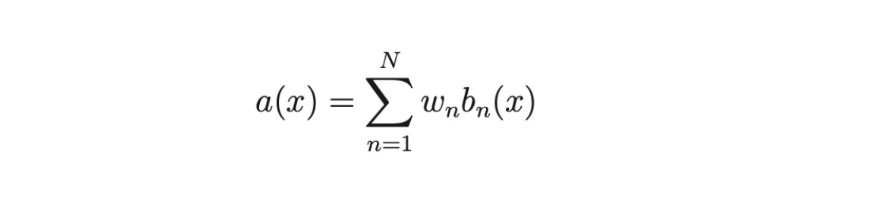

Это самый простой способ объединить несколько алгоритмов в композицию. Иногда даже блендинг без обучения весов(то есть вариант с $w_1 = ... = w_n = 1/N$) позволяет улучшить качество по сравнению с отдельными базовыми алгоритмами. Для простоты воспользуемся этим вариантом.


**Описание используемых функций и их параметров**

pandas.DataFrame(data=None, columns=None) - создает дата фрейм

>- data - двумерный массив с данными.
>- columns - название столбцов.

sklearn.model_selection.train_test_split(arrays1, arrays2, test_size=None, random_state=None, stratify=None)

>- arrays1 - образец набора функций для разделения.
>- arrays2 - образец результата, который нужно разделить.
>- test_size - доля выборок, если это целое число, это количество выборок.
>- random_state - это начальное число случайного числа.

def rmse(y_true, y_pred) - функция рассчитывающая среднеквадратичную ошибку(расстояние между двумя точками)

>- y_true - 1 точка
>- y_pred - 2 точка

StandardScaler() - создаёт объект функции StandardScaler()

object.fit_transform(data) - преобразует данные таким образом, что его распределение будет иметь среднее значение 0 и стандартное отклонение 1

>- data - двумерный массив с данными.

object.fit_transform(data) - Стандартизирует данные

>- data - двумерный массив с данными.

def select_weights(y_true, y_pred_1, y_pred_2) - функция, которая находит взвешенную сумму базовых алгоритмов.

**Решение задачи**

In [ ]:
from sklearn.datasets import fetch_california_housing
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

#!pip install catboost
from catboost import CatBoostRegressor

# Загружаем набор данных
data = fetch_california_housing()

# Считываем DataFrame 
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Делим на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# функция расчета среднеквадратичной ошибки
def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

# Инициализация модели
cbm = CatBoostRegressor(iterations=100, max_depth=4, learning_rate=0.01, loss_function='RMSE', logging_level='Silent')
# Обучение модели
cbm.fit(X_train, y_train)

# Рассчет точности
y_pred_cbm = cbm.predict(X_test)
y_train_pred_cbm = cbm.predict(X_train)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Инициализация модели
lr = LinearRegression()
# Обучение модели
lr.fit(X_train_scaled, y_train)
# Рассчет точности
y_pred_lr = lr.predict(X_test_scaled)
y_train_pred_lr = lr.predict(X_train_scaled)

def select_weights(y_true, y_pred_1, y_pred_2):
    grid = np.linspace(0, 1, 1000)
    metric = []
    for w_0 in grid:
        w_1 = 1 - w_0
        y_a = w_0 * y_pred_1 + w_1 * y_pred_2
        metric.append([rmse(y_true, y_a), w_0, w_1])
    return metric
  
rmse_blending_train, w_0, w_1 = min(select_weights(y_train, y_train_pred_cbm, y_train_pred_lr), key=lambda x: x[0])
rmse(y_test, y_pred_cbm * w_0 +  y_pred_lr * w_1)

0.7255682914828336

**Визуализация результата**

In [ ]:
print("Train RMSE GB = %.4f" % rmse(y_train, y_train_pred_cbm))
print("Test RMSE GB = %.4f" % rmse(y_test, y_pred_cbm))
print("Train RMSE LR = %.4f" % rmse(y_train, y_train_pred_lr))
print("Test RMSE LR = %.4f" % rmse(y_test, y_pred_lr))
print("\n")
print("Train RMSE BL = %.4f" % rmse_blending_train)
print("Test RMSE BL = %.4f" % rmse(y_test, y_pred_cbm * w_0 +  y_pred_lr * w_1))

Train RMSE GB = 0.8162
Test RMSE GB = 0.8272
Train RMSE LR = 0.7168
Test RMSE LR = 0.7443


Train RMSE BL = 0.7053
Test RMSE BL = 0.7256


**Интерпретация результата**

Полученный результат означает, что блендинг без обучения весов позволяет улучшить качество по сравнению с отдельными базовыми алгоритмами.

**Задания для самостоятельной работы**

1. Применить блендинг для логистической и линейной регрессии.
2. Применить блендинг для логистической регрессии и бустинга.